### Boosting a decision stump

In this homework you will implement your own boosting module.

Brace yourselves! This is going to be a fun and challenging assignment.

Use SFrames to do some feature engineering.
Train a boosted ensemble of decision-trees (gradient boosted trees) on the lending club dataset.

Predict whether a loan will default along with prediction probabilities (on a validation set).

Evaluate the trained model and compare it with a baseline.

Find the most positive and negative loans using the learned model.

Explore how the number of trees influences classification performance.

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()

In [96]:
loans = pd.read_csv('lending-club-data.csv')

f:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [97]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'

In [98]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x: 1 if x == 0 else -1)

In [99]:
'bad_loans' in loans.columns

True

In [100]:
loans.drop('bad_loans', axis=1, inplace=True)

In [101]:
'bad_loans' in loans.columns

False

In [102]:
loans = loans[features + [target]]

In [103]:
loans.head()

,grade,term,home_ownership,emp_length,safe_loans
0,B,36 months,RENT,10+ years,1
1,C,60 months,RENT,< 1 year,-1
2,C,36 months,RENT,10+ years,1
3,C,36 months,RENT,10+ years,1
4,A,36 months,RENT,3 years,1


1. Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding. Alternatively, see #7 for implementation hints.

Just like the previous assignment, we will implement binary decision trees. Since all of our features are currently categorical features, we want to turn them into binary features. Here is a reminder of what one-hot encoding is.

In [104]:
loans = pd.get_dummies(loans)

In [105]:
loans.head()

,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,...,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
0,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,-1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [106]:
loans['grade_A'].sum()

22314

2. Load the JSON files into the lists train_idx and test_idx.
3. Perform train/validation split using train_idx and test_idx. In Pandas, for instance:

Note: Some elements in loans are included neither in train_data nor test_data. This is to perform sampling to achieve class balance.

In [107]:
train_idx = pd.read_json('module-8-assignment-2-train-idx.json')
test_idx = pd.read_json('module-8-assignment-2-test-idx.json')
train_data = loans.iloc[train_idx[0]]
test_data = loans.iloc[test_idx[0]]

### Weighted decision trees

Let's modify our decision tree code from Module 5 to support weighting of individual data points.
Weighted error definition 

Consider a model with $N$ data points with: 

Predictions $\hat{y}_1 ... \hat{y}_n$ Target $y_1 ... y_n$ 

Data point weights $\alpha_1 ... \alpha_n$. 

Then the weighted error is defined by: $$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i}
$$ where $1[y_i \neq \hat{y_i}]$ is an indicator function that is set to $1$ if $y_i \neq \hat{y_i}$.

Write a function to compute weight of mistakes Write a function that calculates the weight of mistakes for making the "weighted-majority" predictions for a dataset. 

The function accepts two inputs: 

labels_in_node: Targets $y_1 ... y_n$ 

data_weights: Data point weights $\alpha_1 ... \alpha_n$ 

We are interested in computing the (total) weight of mistakes, i.e. $$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}].
$$ This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way: $$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}
$$ The function intermediate_node_weightedmistakes should first compute two weights: 

$\mathrm{WM}_{-1}$: weight of mistakes when all predictions are $\hat{y_i} = -1$ i.e $\mathrm{WM}(\mathbf{\alpha}, \mathbf{-1}$) 

$\mathrm{WM}_{+1}$: weight of mistakes when all predictions are $\hat{y_i} = +1$ i.e $\mbox{WM}(\mathbf{\alpha}, \mathbf{+1}$) 

where $\mathbf{-1}$ and $\mathbf{+1}$ are vectors where all values are -1 and +1 respectively. 

After computing $\mathrm{WM}_{-1}$ and $\mathrm{WM}_{+1}$, the function intermediate_node_weighted_mistakes should return the lower of the two weights of mistakes, along with the class associated with that weight.


In [108]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    # This is because if we predict it all as negative, the total_weight_positive is 
    # the wrongly categorized weight
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    if weighted_mistakes_all_negative < weighted_mistakes_all_positive:
        return (weighted_mistakes_all_negative, -1)
    else:
        return (weighted_mistakes_all_positive, 1)

### Recall that the classification error is defined as follows:
$$\mathrm{classification\,error} = \frac{\#\,\mathrm{mistakes}}{\#\, \mathrm{all\,data\,points}}$$

Quiz Question: If we set the weights $\alpha = 1$ for all data points, how is the weight of mistakes $ \mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ related to the classification error?  ---> The same

### Function to pick best feature to split on
We continue modifying our decision tree code from the earlier assignment to incorporate weighting of individual data points. The next step is to pick the best feature to split on.

The $\mathrm{best\_splitting\_feature}$ function is similar to the one from the earlier assignment with two minor modifications:

1. The function $\mathrm{best\_splitting\_feature}$ should now accept an extra parameter data_weights to take account of weights of data points.
2. Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.

In [109]:
# If the data is identical in each feature, this function should return None
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        # data_weights[data[splitting_feature] == 0]
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE Calculate the weight of mistakes for left and right sides
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], 
                                                                                 left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], 
                                                                                   right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        error = (left_weighted_mistakes + right_weighted_mistakes) / sum(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature


### Very Optional. Relationship between weighted error and weight of mistakes
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i} = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}.
$$ 

In the code above, we obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$ from the two weights of mistakes from both sides, $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}})$ and $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})$

First, notice that the overall weight of mistakes $\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ can be broken into two weights of mistakes over either side of the split: 

$$ \mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}] = \sum_{\mathrm{left}} \alpha_i \times 1[y_i \neq \hat{y_i}] + 
\sum_{\mathrm{right}} \alpha_i \times 1[y_i \neq \hat{y_i}]\ = 
\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}}) $$ 

We then divide through by the total weight of all data points to obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$:
    $$ \mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})}{\sum_{i=1}^{n}\alpha_i}$$

### ### Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree. Recall from the previous assignments that each node in the decision tree is represented as a dictionary which contains the following keys:

In [ ]:
{ 
   'is_leaf'            : True/False.
   'prediction'         : Prediction at the leaf node.
   'left'               : (dictionary corresponding to the left tree).
   'right'              : (dictionary corresponding to the right tree).
   'features_remaining' : List of features that are posible splits.
}

#### Let us start with a function that creates a leaf node given a set of target values. The create_leaf function should be analogous to the following cell: 

In [111]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    # Store the predicted class (1 or -1) in leaf['prediction']
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    leaf['prediction'] = best_class
    
    return leaf

#### Now write a function that learns a weighted decision tree recursively and implements 3 stopping conditions:

1. All data points in a node are from the same class.

2. No more features to split on.

3. Stop growing the tree when the tree depth reaches ${\mathrm{max\_depth}}$

Since there are many steps involved, we provide you with a Python skeleton, along with explanatory comments.

In [112]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print( "--------------------------------------------------------------------")
    print( "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print( "Stopping condition 1 reached."  )              
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print( "Stopping condition 2 reached."     )           
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print( "Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print( "Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print( "Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print( "Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

#### Finally, write a recursive function to count the nodes in your tree. The function should be analogous to

In [113]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

### Making predictions with a weighted decision tree
To make a single prediction, we must start at the root and traverse down the decision tree in recursive fashion. Write a function classify that makes a single prediction. It should be analogous to the following:



In [114]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print( "At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print( "Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

### Evaluating the tree
Create a function called evaluate_classification_error. It takes in as input:

1. tree (as described above)
2. data (an data frame)

In [116]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    data['prediction'] = [classify(tree, data.iloc[i]) for i in range(len(data))]
    
    # Once you've made the predictions, calculate the classification error
    return 1 - np.sum(data['safe_loans'] == data['prediction']) / len(data)

### To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the first 10 and last 10 items in train_data, we assign weights:

1. 1 to the last 10 items
2. 1 to the first 10 items
3. and 0 to the rest.

#### Let us fit a weighted decision tree with max_depth = 2. Then compute the classification error on the subset_20, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [117]:
# Assign weights
example_data_weights = np.ones(
    10 * 1).tolist() + [0.] * (len(train_data) - 20) + np.ones(1 * 10).tolist()
example_data_weights = np.array(example_data_weights)

In [118]:
example_data_weights

array([1., 1., 1., ..., 1., 1., 1.])

In [119]:
train_data.columns.tolist()

['safe_loans',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'term_ 36 months',
 'term_ 60 months',
 'home_ownership_MORTGAGE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year']

In [120]:
feature_list = train_data.columns.tolist()[1:]

In [127]:
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, feature_list, target,
                                        example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

#### Now, we will compute the classification error on the subset_20, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

The model small_data_decision_tree_subset_20 performs a lot better on subset_20 than on train_data.

So, what does this mean?

1. The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
2. The points with zero weights are basically ignored during training.

Quiz Question: Will you get the same model as small_data_decision_tree_subset_20 if you trained a decision tree with only the 20 data points with non-zero weights from the set of points in subset_20?

In [128]:
small_data_decision_tree_subset_20

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade_F'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade_D'},
 'splitting_feature': 'home_ownership_RENT'}

In [129]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.050000000000000044

In [130]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

f:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.4812486567805717

In [131]:
evaluate_classification_error(small_data_decision_tree_subset_20, test_data)

f:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.47953468332615257

### Implementing your own Adaboost (on decision stumps)

Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. 

For the sake of simplicity, let us stick with decision tree stumps by training trees with max_depth=1.

Recall from the lecture the procedure for Adaboost:

Start with unweighted data with $\alpha_j = 1$

For t = 1,...T: Learn $f_t(x)$ with data weights $\alpha_j$

Compute coefficient $\hat{w}_t$: $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$ Re-compute weights $\alpha_j$: $$\alpha_j \gets \begin{cases}
\alpha_j \exp{(-\hat{w}_t)} \, \text{ if }\, f_t(x_j) = y_j\\
\alpha_j \exp{(\hat{w}_t)} \, \text{ if }\, f_t(x_j) \neq y_j
\end{cases}$$ Normalize weights $\alpha_j$: $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$ 

Now write your own Adaboost function. The function accepts 4 parameters:

1. data: a data frame with binary features
2. features: list of feature names
3. target: name of target column
4. num_tree_stumps: number of tree stumps to train for the ensemble

The function should return the list of tree stumps, along with the list of corresponding tree stump weights.

In [132]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.ones(len(data)*1)
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print( '=====================================================')
        print( 'Adaboost Iteration %d' % t)
        print( '=====================================================')    
        # Learn a weighted decision tree stump. Use max_depth=1
        # If we choose different max_depth, we will build normal decision tree as each classifier 
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        data['prediction'] = [classify(tree_stump, data.iloc[i]) for i in range(len(data))]
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = data['prediction'] == target_values
        is_wrong   = data['prediction'] != target_values
        
        # Compute weighted error
        weighted_error = sum(alpha[is_wrong]) / sum(alpha)
        
        # Compute model coefficient using weighted error
        weight = 0.5 * log((1 - weighted_error) / weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        # adjustment is Series
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment
        alpha = alpha * adjustment
        # Then normalize data points weights
        alpha = alpha / sum(alpha)
    
    return weights, tree_stumps

In [133]:
sum(pd.Series((True, False)) * np.array((1, 2))) / sum(np.array((1, 2)))

0.3333333333333333

#### Reminders

Stump weights $\mathbf{\hat{w}} $ and data point weights $\mathbf{\alpha}$ are two different concepts.
1. Stump weights $\mathbf{\hat{w}} $ tell you how important each stump is while making predictions with the entire boosted ensemble.
2. Data point weights $\mathbf{\alpha}$ tell you how important each data point is while training a decision stump.

### Training a boosted ensemble of 10 stumps
Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the adaboost_with_tree_stumps function with the following parameters:

1. train_data
2. features
3. target
4. num_tree_stumps = 10

In [134]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, feature_list, target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.


f:\anaconda\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_D. (30465, 6759)
--------------------------------------------------------------------
Subtree, depth = 2 (30465 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (6759 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 3
-----------------------------------------

In [135]:
def print_stump(tree, name = 'root'):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print( "(leaf, label: %s)" % tree['prediction'])
        return None
    split_feature, split_value = split_name.split('_')
    print( '                       %s' % name)
    print('         |---------------|----------------|')
    print( '         |                                |')
    print( '         |                                |')
    print( '         |                                |')
    print( '  [{0} == 0]               [{0} == 1]    '.format(split_name))
    print( '         |                                |')
    print( '         |                                |')
    print( '         |                                |')
    print( '    (%s)                         (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))

#### Quiz Question: Are the weights monotonically decreasing, monotonically increasing, or neither?

In [136]:
stump_weights

[0.15802933659263743,
 0.1768236329364191,
 0.09311888971129693,
 0.07288885525840554,
 0.06706306914118143,
 0.06456916961644447,
 0.05456055779178564,
 0.04351093673362621,
 0.02898871150041245,
 0.01933343817072769]

In [33]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_A == 0]               [grade_A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                         (leaf, label: 1)


In [35]:
print_stump(tree_stumps[9])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_A == 0]               [grade_A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: 1)                         (leaf, label: 1)


### Training a boosted ensemble of 10 stumps

Recall from the lecture that in order to make predictions, we use the following formula: $$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$ 
We need to do the following things: 
1. Compute the predictions $f_t(x)$ using the $t$-th decision tree 

2. Compute $\hat{w}_t f_t(x)$ by multiplying the stump_weights with the predictions $f_t(x)$ from the decision trees

3. Sum the weighted predictions over each stump in the ensemble. Complete the following skeleton for making predictions:

Reminder: Stump weights $\mathbf{\hat{w}} $
tell you how important each stump is while making predictions with the entire boosted ensemble.

In [137]:
stump_weights_30, tree_stumps_30 = adaboost_with_tree_stumps(train_data, feature_list, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.


f:\anaconda\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_D. (30465, 6759)
--------------------------------------------------------------------
Subtree, depth = 2 (30465 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (6759 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 3
-----------------------------------------

Split on feature emp_length_4 years. (34593, 2631)
--------------------------------------------------------------------
Subtree, depth = 2 (34593 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (2631 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_F. (35512, 1712)
--------------------------------------------------------------------
Subtree, depth = 2 (35512 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (1712 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 17
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature emp_length_2 years. (33652, 3572

In [138]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.zeros(len(data)*1)
    
    for i, tree_stump in enumerate(tree_stumps):
        data['prediction'] = [classify(tree_stump, data.iloc[i]) for i in range(len(data))]
        
        # Accumulate predictions on scaores array
        scores += stump_weights[i] * data['prediction']
#     data['scores'] = scores
    
    return scores.apply(lambda score : +1 if score > 0 else -1)

### Performance plots

How does accuracy change with adding stumps to the ensemble?

We will now train an ensemble with:

1. train_data
2. features
3. target
4. num_tree_stumps = 30

Once we are done with this, we will then do the following:

Compute the classification error at the end of each iteration.
Plot a curve of classification error vs iteration.
First, let's train the model.

Computing training error at the end of each iteration

Let us compute the classification error on the train_data and see how it is reduced as trees are added.

For n = 1 to 30, do the following:

1. Make predictions on train_data using tree stumps 0, ..., n-1. Means use differnt number of tree stumps
2. Compute classification error for the predictions
3. Record the classification error for that n.

The loop should be analogous to the following:

In [139]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights_30[:n], tree_stumps_30[:n], train_data)
    error = 1.0 - sum(predictions == train_data[target]) / len(train_data)
    error_all.append(error)
    print("Iteration %s, training error = %s" % (n, error_all[n-1]))

f:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.43343004513217276
Iteration 3, training error = 0.4000376101439931
Iteration 4, training error = 0.4000376101439931
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.3846174511068128
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.3846174511068128
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.38144745325596385
Iteration 11, training error = 0.38144745325596385
Iteration 12, training error = 0.38144745325596385
Iteration 13, training error = 0.38144745325596385
Iteration 14, training error = 0.38144745325596385
Iteration 15, training error = 0.38144745325596385
Iteration 16, training error = 0.3814205888673974
Iteration 17, training error = 0.3814205888673974
Iteration 18, training error = 0.3816355039759295
Iteration 19, training error = 0.3816355039759295
Iteration 20, training error = 0.3816355039759295
It

### Visualizing training error vs number of iterations
Let us generate the plot of classification error as a function of the number of iterations. Use the classification error values recorded in #23.

Quiz Question: Which of the following best describes a general trend in accuracy as we add more and more components? Answer based on the 30 components learned so far.

1. Training error goes down monotonically, i.e. the training error reduces with each iteration but never increases.
2. Training error goes down in general, with some ups and downs in the middle.
3. Training error goes up in general, with some ups and downs in the middle.
4. Training error goes down in the beginning, achieves the best error, and then goes up sharply.
5. None of the above

A: 2

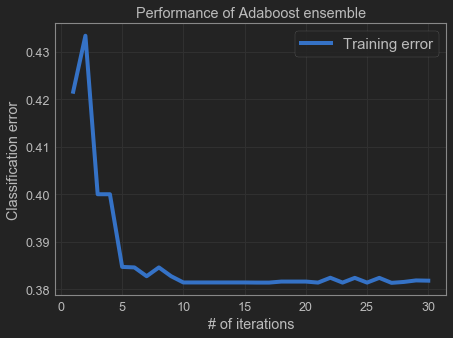

In [142]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

### Evaluation on the test data
Performing well on the training data is cheating, so lets make sure it works on the test_data as well. Here, we will compute the classification error on the test_data at the end of each iteration.

For n = 1 to 30, do the following:

1. Make predictions on test_data using tree stumps 0, ..., n-1.
2. Compute classification error for the predictions
3. Record the classification error for that n.
4. Visualize both the training and test errors

In [ ]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights_30[:n], tree_stumps_30[:n], test_data)
    error = 1.0 - sum(predictions == test_data[target]) / len(test_data)
    test_error_all.append(error)
    print("Iteration %s, training error = %s" % (n, test_error_all[n-1]))

In [ ]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()